# Chapter 1: Bigram Language Model

A character-level bigram language model for name generation, implemented two ways:
1. A counting-based statistical approach
2. An equivalent single-layer neural network

Following Karpathy's makemore Part 1.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

## Dataset

Load and explore the names.txt dataset — ~32K human names, one per line.

In [2]:
words = open('../data/names.txt', 'r').read().splitlines()
print(f"Number of names: {len(words)}")
print(f"First 10: {words[:10]}")
print(f"Shortest: {min(words, key=len)} ({min(len(w) for w in words)} chars)")
print(f"Longest: {max(words, key=len)} ({max(len(w) for w in words)} chars)")

Number of names: 32033
First 10: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
Shortest: an (2 chars)
Longest: muhammadibrahim (15 chars)


In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0  # boundary token
itos = {i: s for s, i in stoi.items()}
vocab_size = len(stoi)

print(f"Vocab size: {vocab_size}")
print(f"Characters: {chars}")
assert vocab_size == 27, f"Expected 27, got {vocab_size}"

Vocab size: 27
Characters: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## Counting-Based Bigram Model

Build a 27×27 count matrix of character pair frequencies, normalize to probabilities, and use for loss computation and sampling.

In [6]:
N = torch.zeros((27, 27), dtype=torch.int32)
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

print(f"Total bigrams counted: {N.sum().item()}")

Total bigrams counted: 228146


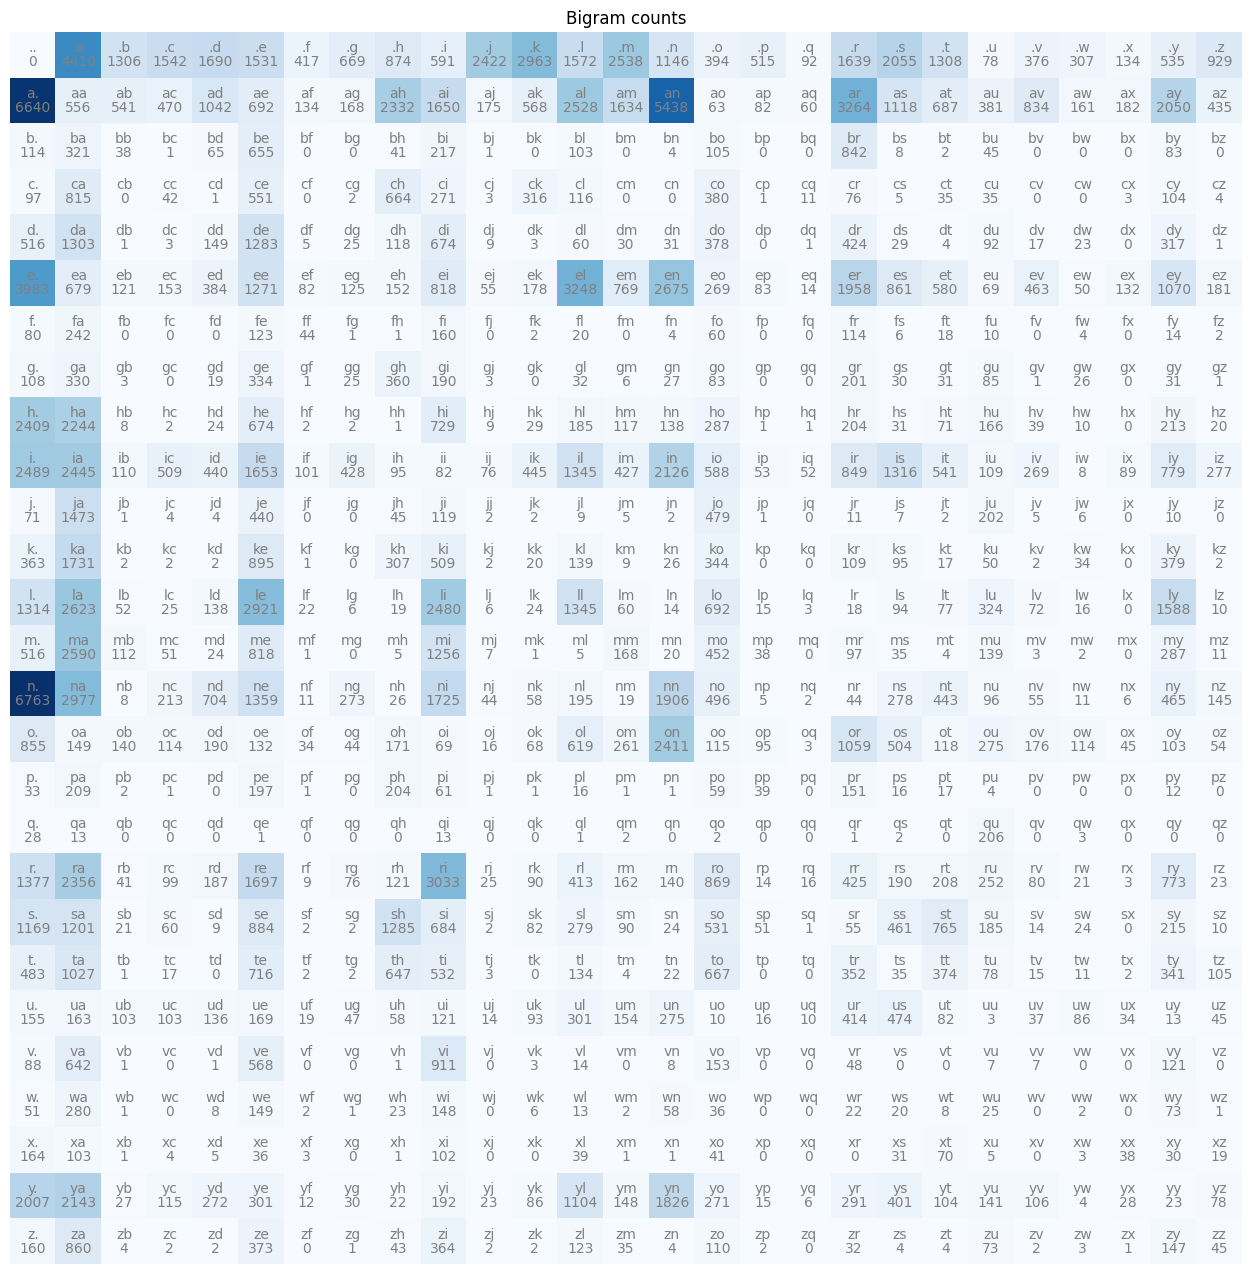

In [7]:
plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off')
plt.title('Bigram counts')
plt.show()

In [8]:
P = (N + 1).float()  # add-1 smoothing to avoid log(0)
P = P / P.sum(dim=1, keepdim=True)

# Verify it's a valid probability distribution
assert torch.allclose(P.sum(dim=1), torch.ones(27)), "Rows should sum to 1"

In [9]:
log_likelihood = 0.0
n = 0
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        log_likelihood += torch.log(P[ix1, ix2])
        n += 1

nll = -log_likelihood / n
print(f"Counting model NLL: {nll.item():.4f}")
assert 2.0 < nll.item() < 3.0, f"NLL {nll.item()} outside expected range"

Counting model NLL: 2.4544


In [10]:
g = torch.Generator().manual_seed(2147483647)

print("Counting model samples:")
for i in range(10):
    out = []
    ix = 0  # start with boundary token
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        if ix == 0:
            break
        out.append(itos[ix])
    print(''.join(out))

Counting model samples:
cexze
momasurailezitynn
konimittain
llayn
ka
da
staiyaubrtthrigotai
moliellavo
ke
teda


## Neural Bigram Model

The same bigram model, but as a single-layer neural network trained with gradient descent. The key insight: both approaches should converge to the same distribution (same loss).

In [11]:
xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print(f"Training examples: {num}")

Training examples: 228146


In [12]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [13]:
for k in range(100):
    # Forward pass
    xenc = F.one_hot(xs, num_classes=27).float()  # one-hot encode inputs
    logits = xenc @ W  # predict log-counts
    counts = logits.exp()  # "counts" (unnormalized probabilities)
    probs = counts / counts.sum(1, keepdims=True)  # probabilities
    loss = -probs[torch.arange(num), ys].log().mean()  # NLL loss

    # Add regularization to encourage smoothing (equivalent to add-1 smoothing)
    loss += 0.01 * (W**2).mean()

    # Backward pass
    W.grad = None
    loss.backward()

    # Update
    W.data += -50 * W.grad

print(f"Neural model NLL: {loss.item():.4f}")

Neural model NLL: 2.4901


In [14]:
# The neural model should converge close to the counting model's loss
print(f"Counting model NLL: {nll.item():.4f}")
print(f"Neural model NLL:   {loss.item():.4f}")
print(f"Difference:         {abs(nll.item() - loss.item()):.4f}")

# They won't be exactly equal due to regularization, but should be close
assert abs(nll.item() - loss.item()) < 0.15, "Neural model should be close to counting model"

Counting model NLL: 2.4544
Neural model NLL:   2.4901
Difference:         0.0358


In [15]:
g = torch.Generator().manual_seed(2147483647)

print("Neural model samples:")
for i in range(10):
    out = []
    ix = 0
    while True:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W
        counts = logits.exp()
        p = counts / counts.sum(1, keepdims=True)
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        if ix == 0:
            break
        out.append(itos[ix])
    print(''.join(out))

Neural model samples:
cexze
momasurailezityha
konimittain
llayn
ka
da
staiyaubrtthrigotai
moliellavo
ke
teda


## Summary

Both approaches model the same thing: **P(next_char | current_char)**.

- The **counting approach** is exact given the data — count bigrams, normalize, done.
- The **neural approach** learns the same distribution via gradient descent on a single weight matrix `W`.

The neural approach generalizes: replace the single linear layer with a deeper network and you get an MLP (Chapter 3), then a transformer (Chapter 4+).

**Key concepts established:**
- NLL loss as the standard measure of language model quality
- Softmax for converting logits to probabilities
- One-hot encoding of discrete inputs
- Gradient descent training loop (forward → loss → backward → update)
- Sampling from learned distributions to generate text